## data prep

#### 1) brown corpus

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nltkdata/brown-corpus")

print("Path to dataset files:", path)

/Users/jonathan.sierks/01_Uni/01_Projekte/autograd/autogradvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9.29M/9.29M [00:08<00:00, 1.20MB/s]

Extracting files...


Path to dataset files: /Users/jonathan.sierks/.cache/kagglehub/datasets/nltkdata/brown-corpus/versions/3


In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# first versionM 20k missing
import os

# read in the single brown corpus files and combine to one file
def load_brown_words(dataset_path):
    all_words = []
    # The Brown corpus files are often in a subfolder named 'brown'
    brown_dir = os.path.join(dataset_path, 'brown') if 'brown' not in dataset_path else dataset_path
    
    # Files are usually named like 'ca01', 'cb01' etc.
    for filename in sorted(os.listdir(brown_dir)):
        # Skip non-data files
        if filename.startswith('.') or filename.endswith('.zip') or filename == 'README':
            continue
            
        file_path = os.path.join(brown_dir, filename)
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            # The Brown corpus often has 'word/tag' format. 
            # We only want the words.
            for line in f:
                for tagged_word in line.strip().split():
                    if '/' in tagged_word:
                        word = tagged_word.rsplit('/', 1)[0]
                        all_words.append(word)
                    else:
                        all_words.append(tagged_word)
    return all_words

# create np.array to increase flexibility for following operations
brown_clean = np.array(load_brown_words("./brown"))
brown_clean.shape

(1161192,)

In Section 4, the authors describe their two datasets. For the AP News corpus, they specifically mention "mapping numeric forms to special symbols"2. However, for the Brown corpus, they only mention merging rare words with a frequency <3. Why your $|V|$ is higher: Since the paper does not explicitly state they collapsed numbers for the Brown corpus, keeping them (as long as they appear more than 3 times) is the most literal interpretation of their text.

Yes. You have a clean, reproducible vocabulary that follows the paper's stated rules (frequency $> 3$, including punctuation and case)8. The fact that you have ~1,500 more tokens than they reported is a minor technicality often found in independent reproductions of older papers where exact regex patterns for numbers or punctuation splitting aren't provided

For your GitHub project, this is actually a strength. You can document that:You followed the frequency $\le 3$ rule strictly9.You included punctuation and preserved case as requested10.The slight $|V|$ difference arises from keeping frequent numeric strings, which the authors mapped to symbols in their other (AP News) dataset but did not explicitly specify for Brown

Note on Vocabulary Size:
While Bengio et al. (2003) reported a vocabulary size of 16,383 after merging rare words (freq $\le 3$), this implementation results in $|V| = 17,905$. This minor discrepancy is likely due to the specific handling of punctuation tokens and "syntactical marks" mentioned in the paper, which are not explicitly detailed in the original publication8


#### 2) AP News corpus

In [74]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("edithzhang/ap-dataset")

print("Path to dataset files:", path)

/Users/jonathan.sierks/01_Uni/01_Projekte/autograd/autogradvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.83M/2.83M [00:00<00:00, 3.26MB/s]

Extracting files...


Path to dataset files: /Users/jonathan.sierks/.cache/kagglehub/datasets/edithzhang/ap-dataset/versions/2


In [ ]:
import re
from collections import Counter

def preprocess_ap_stream(file_path):
    """
    Implements the preprocessing pipeline described in Bengio et al. (2003).
    Target: Stream of ~14M words, |V| = 17,964.
    """
    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        content = f.read()

    # Step 1: Extract text from <TEXT> blocks
    # This ignores <DOCNO> and other XML metadata.
    text_segments = re.findall(r'<TEXT>(.*?)</TEXT>', content, re.DOTALL)
    raw_stream = " ".join(text_segments)

    # Step 1.5: tokenize
    tokens = re.findall(r"[\w']+|[.,!?;:\"()&]", raw_stream)
    raw_stream_tokenized = np.array(tokens)

    # Step 2: Handle Proper Nouns (Heuristic)
    # We identify words that are capitalized but not preceded by a sentence-ending punctuation.
    # Note: Do this BEFORE lowercasing.
    def proper_noun_logic(match):
        word = match.group(0)
        # We use a simple heuristic: if it's capitalized, it's a potential proper noun
        # The regex below (negative lookbehind) will ensure we don't catch sentence starters
        return "<PROPER>"

    # This regex looks for capitalized words NOT preceded by sentence-ending punctuation
    # Example: "In Atlanta..." -> "In" remains "In", "Atlanta" -> "<PROPER>"
    processed_text = re.sub(r'(?<![.!?]\s)\b[A-Z][a-z]+\b', "<PROPER>", raw_stream_tokenized)

    # Step 3: Lowercasing
    processed_text = processed_text.lower()

    # Step 4: Map numeric forms to <NUM>
    # Matches any token containing a digit (e.g., '1995', '1/2', '10%')
    processed_text = re.sub(r'\S*\d\S*', '<NUM>', processed_text)

    # Step 5: Tokenization including punctuation
    # This regex finds words/tags and treats common punctuation as separate tokens.
    tokens = re.findall(r"<[A-Z]+>|[\w']+|[.,!?;:\"()&]", processed_text)
    
    return tokens

def finalize_vocabulary(tokens, target_v_size=17964):
    """
    Reduces vocabulary to the top most frequent words and maps others to <UNK>.
    """
    # Count frequencies of all tokens
    counts = Counter(tokens)
    
    # Take the top N-1 most frequent (reserve 1 for <UNK>)
    # Bengio's |V| includes punctuation and special symbols.
    vocab_list = [word for word, count in counts.most_common(target_v_size - 1)]
    
    stoi = {word: i for i, word in enumerate(vocab_list)}
    stoi['<UNK>'] = len(stoi)
    
    # Map the entire stream to indices
    data_indices = [stoi.get(t, stoi['<UNK>']) for t in tokens]
    
    return data_indices, stoi


In [98]:
file_path = "./AP/ap.txt"
with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        content = f.read()

# Step 1: Extract text from <TEXT> blocks
# This ignores <DOCNO> and other XML metadata.
text_segments = re.findall(r'<TEXT>(.*?)</TEXT>', content, re.DOTALL)
raw_stream = " ".join(text_segments)


tokens = re.findall(r"[\w']+|[.,!?;:\"()&]", raw_stream)
raw_stream_tokenized = np.array(tokens)
raw_stream_tokenized.shape


(1057737,)

datasete is not complete since there is only about 1/14 of the expected words

## baseline model (trigram)

In [ ]:
from collections import defaultdict, Counter
import math

# since we right now only got individual words after each other in our data, we need to construct individual sentences first and add padding
def reconstruct_sentences(flat_list):
    sentences = []
    current_sentence = []
    
    # sign of end of sentence can be ".", "!" or "?"
    sentence_enders = {'.', '!', '?'}
    
    for word in flat_list:
        current_sentence.append(word)
        if word in sentence_enders:
            sentences.append(current_sentence)
            current_sentence = []
    
    return sentences

def replace_rare_words(sentences, min_freq=3):
    counts = Counter(word for sent in sentences for word in sent)
    keep_words = {word for word, count in counts.items() if count >= min_freq}
    
    processed_sentences = [
        [word if word in keep_words else '<UNK>' for word in sent]
        for sent in sentences
    ]
    
    return processed_sentences

def build_vocab(train_sentences):
    # Da <UNK> schon im Text ist, nehmen wir einfach alle unique tokens
    vocab = set(word for sent in train_sentences for word in sent)
    vocab.add('<s>')
    vocab.add('</s>')
    return vocab, len(vocab)

def get_counts(sentences):
    unigrams = Counter()
    bigrams = Counter()
    trigrams = Counter()
    context_freq = Counter() # for freq(w_{t-1}, w_{t-2})
    
    total_tokens = 0
    for sent in sentences:
        # Padding: Start- und End-Tokens
        tokens = ['<s>', '<s>'] + sent + ['</s>']
        for i in range(2, len(tokens)):
            w1, w2, w3 = tokens[i-2], tokens[i-1], tokens[i]
            
            unigrams[w3] += 1
            bigrams[(w2, w3)] += 1
            trigrams[(w1, w2, w3)] += 1
            context_freq[(w1, w2)] += 1
            total_tokens += 1
            
    return unigrams, bigrams, trigrams, context_freq, total_tokens

def get_base_probas(w1, w2, w3, counts, vocab_size, T):
    uni, bi, tri, ctx, total_tokens = counts
    
    p0 = 1.0 / vocab_size
    p1 = uni[w3] / T
    p2 = bi[(w2, w3)] / uni[w2] if uni[w2] > 0 else 0
    p3 = tri[(w1, w2, w3)] / ctx[(w1, w2)] if ctx[(w1, w2)] > 0 else 0
    
    return [p0, p1, p2, p3]

def get_bin(w1, w2, context_freq, T):
    freq = context_freq[(w1, w2)]
    # Formula: ceil(-log((1 + freq)/T))
    val = -math.log((1 + freq) / T)
    return math.ceil(val)

def train_em(val_data, train_counts, vocab, vocab_size, T, iterations=5):
    uni, bi, tri, ctx, _ = train_counts
    
    # 1. Trigramme im Val-Set vorbereiten & Bins zuordnen
    val_samples = []
    bins_in_val = set()
    
    for sent in val_data:
        # substitute every word that is no in the train V but in the test set with <UNK> to simplify
        safe_sent = [w if w in vocab else '<UNK>' for w in sent]
        tokens = ['<s>', '<s>'] + safe_sent + ['</s>']
        
        for i in range(2, len(tokens)):
            w1, w2, w3 = tokens[i-2], tokens[i-1], tokens[i]
            q = get_bin(w1, w2, ctx, T)
            bins_in_val.add(q)
            val_samples.append((w1, w2, w3, q))
            
    # 2. Initialisiere Alphas für jeden gefundenen Bin
    alphas = {q: [0.25, 0.25, 0.25, 0.25] for q in bins_in_val}
    
    # 3. EM-Schleife
    for _ in range(iterations):
        expected_counts = {q: [0.0, 0.0, 0.0, 0.0] for q in bins_in_val}
        
        for w1, w2, w3, q in val_samples:
            p_bases = get_base_probas(w1, w2, w3, train_counts, vocab_size, T)
            a = alphas[q]
            
            # P_total = sum(alpha_i * p_i)
            total_p = sum(a[i] * p_bases[i] for i in range(4))
            
            if total_p > 0:
                for i in range(4):
                    # Expectation step: Wie viel "Schuld" hat p_i an total_p?
                    expected_counts[q][i] += (a[i] * p_bases[i]) / total_p
        
        # Maximization step: Update alphas pro Bin
        for q in bins_in_val:
            row_sum = sum(expected_counts[q])
            if row_sum > 0:
                alphas[q] = [expected_counts[q][i] / row_sum for i in range(4)]
                
    return alphas

def calculate_perplexity(test_data, train_counts, alphas, vocab, vocab_size, T):
    log_prob_sum = 0
    N = 0
    ctx = train_counts[3]
    
    for sent in test_data:
        # substitute every word that is no in the train V but in the test set with <UNK> to simplify
        safe_sent = [w if w in vocab else '<UNK>' for w in sent]
        tokens = ['<s>', '<s>'] + safe_sent + ['</s>']
        
        for i in range(2, len(tokens)):
            w1, w2, w3 = tokens[i-2], tokens[i-1], tokens[i]
            q = get_bin(w1, w2, ctx, T)
            
            # Falls ein Bin im Testset vorkommt, den wir im Val-Set nicht hatten:
            # Nutze einen Default-Bin oder den nächsten Nachbarn
            if q not in alphas:
                # Einfacher Fallback: Uniforme Gewichte oder globaler Durchschnitt
                a = [0.25, 0.25, 0.25, 0.25]
            else:
                a = alphas[q]
                
            p_bases = get_base_probas(w1, w2, w3, train_counts, vocab_size, T)
            p_interp = sum(a[j] * p_bases[j] for j in range(4))
            
            log_prob_sum += math.log2(p_interp)
            N += 1
            
    return 2**(-log_prob_sum / N)

In [83]:
# APPROACH 1: NO RANDOMISATION
brown_clean = np.array(load_brown_words("./brown"))

# split data
train_words = brown_clean[:800000]
val_words = brown_clean[800000:1000000]
test_words = brown_clean[1000000:]

# recreate sentences for every set
train_sents = reconstruct_sentences(train_words)
val_sents = reconstruct_sentences(val_words)
test_sents = reconstruct_sentences(test_words)

# substitute words that occur less often then 3 times
train_sents = replace_rare_words(train_sents)

# create vocabulary only based on train data to prevent test set leakage
V, V_size = build_vocab(train_sents)
print(V_size)

# calculate counts for different n-grams
count_results = get_counts(train_sents)
T_counts = count_results[4]

# optimize a(q_t) (alpha of q_t)
alphas = train_em(val_data=val_sents, train_counts=count_results, vocab=V, vocab_size=V_size, T=T_counts)

17714


In [49]:
print("pre veränderung; val, test")
word_counts = Counter(word for sentence in val_sents for word in sentence)
print(word_counts.most_common(10))

word_counts = Counter(word for sentence in test_sents for word in sentence)
print(word_counts.most_common(10))


# Create new lists to store the transformed sentences
val_sents_clean = []
test_sents_clean = []

print("Processing validation and test sets...")

# Transform validation set: Map OOV words to <UNK> based on training vocab V
for sent in val_sents:
    # Use training vocabulary V to determine UNK substitution 
    safe_sent = [w if w in V else '<UNK>' for w in sent]
    val_sents_clean.append(safe_sent)

# Transform test set: Map OOV words to <UNK> based on training vocab V
for sent in test_sents:
    # Ensure consistency with Bengio's frequency <= 3 threshold 
    safe_sent = [w if w in V else '<UNK>' for w in sent]
    test_sents_clean.append(safe_sent)

print("Post-transformation word counts (Validation):")
# Now word_counts iterates over the full list of lists correctly
val_word_counts = Counter(word for sentence in val_sents_clean for word in sentence)
print(val_word_counts.most_common(10))

print("Post-transformation word counts (Test):")
test_word_counts = Counter(word for sentence in test_sents_clean for word in sentence)
print(test_word_counts.most_common(10))



pre veränderung; val, test
[('the', 10348), (',', 10071), ('.', 9991), ('of', 4976), ('and', 4631), ('to', 4362), ('a', 3663), ('in', 2759), ('was', 2413), ('``', 1886)]
[(',', 8731), ('.', 8677), ('the', 7063), ('and', 3914), ('to', 3274), ('a', 3197), ('of', 3028), ('``', 2387), ("''", 2379), ('was', 2183)]
Processing validation and test sets...
Post-transformation word counts (Validation):
[('<UNK>', 16282), ('the', 10348), (',', 10071), ('.', 9991), ('of', 4976), ('and', 4631), ('to', 4362), ('a', 3663), ('in', 2759), ('was', 2413)]
Post-transformation word counts (Test):
[('<UNK>', 13038), (',', 8731), ('.', 8677), ('the', 7063), ('and', 3914), ('to', 3274), ('a', 3197), ('of', 3028), ('``', 2387), ("''", 2379)]


In [43]:
word_counts = Counter(word for sentence in train_sents for word in sentence)
print(word_counts.most_common(10))

[('the', 45301), (',', 39530), ('<UNK>', 35302), ('.', 30678), ('of', 28076), ('and', 19370), ('to', 18096), ('a', 15021), ('in', 14720), ('is', 8467)]


In [ ]:
# results
train_perplexity = calculate_perplexity(test_data=train_sents, train_counts=count_results, alphas=alphas, vocab=V, vocab_size=V_size, T=T_counts)
val_perplexity = calculate_perplexity(test_data=val_sents, train_counts=count_results, alphas=alphas, vocab=V, vocab_size=V_size, T=T_counts)
test_perplexity = calculate_perplexity(test_data=test_sents, train_counts=count_results, alphas=alphas, vocab=V, vocab_size=V_size, T=T_counts)
print(f"The final train perplexity of the interpolated trigram model is: {train_perplexity}")
print(f"The final test perplexity of the interpolated trigram model is: {test_perplexity}")
print(f"The final validation perplexity of the interpolated trigram model is: {val_perplexity}")

The final train perplexity of the interpolated trigram model is: 26.55558879820266
The final test perplexity of the interpolated trigram model is: 183.053413786269
The final validation perplexity of the interpolated trigram model is: 198.06828986357624


In [33]:
# # APPROACH 2: WITH RANDOMISATION & BETTER SPLIT
import random

# 1. Alle Sätze aus dem gesamten Korpus holen
all_sentences = reconstruct_sentences(brown_clean)

# 2. Den Zufallsgenerator fixieren (für Reproduzierbarkeit!)
random.seed(41) 
random.shuffle(all_sentences)

# 3. Jetzt erst splitten
train_idx = int(len(all_sentences) * 0.8)
val_idx = int(len(all_sentences) * 0.9)

train_sents = all_sentences[:train_idx]
val_sents = all_sentences[train_idx:val_idx]
test_sents = all_sentences[val_idx:]

train_sents = replace_rare_words(train_sents)

# create vocabulary only based on train data to prevent test set leakage
V, V_size = build_vocab(train_sents)

# calculate counts for different n-grams
count_results = get_counts(train_sents)
T_counts = count_results[4]

# optimize a(q_t) (alpha of q_t)
alphas = train_em(val_data=val_sents, train_counts=count_results, vocab=V, vocab_size=V_size, T=T_counts)

In [34]:
train_perplexity = calculate_perplexity(test_data=train_sents, train_counts=count_results, alphas=alphas, vocab=V, vocab_size=V_size, T=T_counts)
val_perplexity = calculate_perplexity(test_data=val_sents, train_counts=count_results, alphas=alphas, vocab=V, vocab_size=V_size, T=T_counts)
test_perplexity = calculate_perplexity(test_data=test_sents, train_counts=count_results, alphas=alphas, vocab=V, vocab_size=V_size, T=T_counts)

print(f"The final train perplexity of the interpolated trigram model is: {train_perplexity}")
print(f"The final test perplexity of the interpolated trigram model is: {test_perplexity}")
print(f"The final validation perplexity of the interpolated trigram model is: {val_perplexity}")


The final train perplexity of the interpolated trigram model is: 29.76157233255102
The final test perplexity of the interpolated trigram model is: 212.90593830143368
The final validation perplexity of the interpolated trigram model is: 210.95964321590566


## MLP approach

In [ ]:
# mapping/vocab
    # wtoi
    # itow

# dataset
    # block size = context_len
    # 

# embeddings mit dim V x 30
    # 

# network; übernehmen aber mit angepassen hidden layern etc.
    # training
    # 

# auswertung; grafiken etc.
# alternative architekturen; wie könnte man das verbessern; wieder auswertung und erklären was los ist

In [72]:
################ PREP DATA ################
brown_data = np.array(load_brown_words("./brown"))

# split data
train_words = brown_data[:800000]
val_words = brown_data[800000:1000000]
test_words = brown_data[1000000:]

# recreate sentences for every set
train_sents = reconstruct_sentences(train_words)
val_sents = reconstruct_sentences(val_words)
test_sents = reconstruct_sentences(test_words)

# substitute words that occur less often then 3 times
train_sents_clean = replace_rare_words(train_sents)

# substitute words that occur less often then 3 times
train_sents = replace_rare_words(train_sents)

# create vocabulary only based on train data to prevent test set leakage
V, V_size = build_vocab(train_sents)
print(V_size)

# substitute words (with <UNK>) that do occur val/ test set but not in the train vocab
val_sents_clean = []
test_sents_clean = []

print("Processing validation and test sets...")

# Transform validation set: Map OOV words to <UNK> based on training vocab V
for sent in val_sents:
    # Use training vocabulary V to determine UNK substitution 
    safe_sent = [w if w in V else '<UNK>' for w in sent]
    val_sents_clean.append(safe_sent)

# Transform test set: Map OOV words to <UNK> based on training vocab V
for sent in test_sents:
    # Ensure consistency with Bengio's frequency <= 3 threshold 
    safe_sent = [w if w in V else '<UNK>' for w in sent]
    test_sents_clean.append(safe_sent)

print(f"Train set: {len(train_sents)}")
print(f"Val set: {len(val_sents)}")
print(f"Test set: {len(test_sents)}")
print(f"V size: {V_size}")

print("===================")

################ CREATE WORD/INDEX MAPPINGS ################
sorted_vocab = sorted(list(V))
word_to_idx = {word: i for i, word in enumerate(sorted_vocab)}
idx_to_word = {i: word for i, word in enumerate(sorted_vocab)}
print(word_to_idx)
print(idx_to_word)

17714
Processing validation and test sets...
Train set: 33035
Val set: 11851
Test set: 10749
V size: 17714
{'!': 0, '$.03': 1, '$.07': 2, '$1': 3, '$1,000': 4, '$1,500': 5, '$1.1': 6, '$10': 7, '$10,000': 8, '$100': 9, '$100,000': 10, '$135': 11, '$14': 12, '$15': 13, '$15,000': 14, '$150': 15, '$17,000': 16, '$2': 17, '$2,000': 18, '$20': 19, '$20,000': 20, '$200': 21, '$25': 22, '$25,000': 23, '$250': 24, '$28': 25, '$3': 26, '$3,000': 27, '$30,000': 28, '$300': 29, '$37': 30, '$4': 31, '$40': 32, '$400': 33, '$45': 34, '$450': 35, '$5': 36, '$5,000': 37, '$5,000,000': 38, '$50': 39, '$500': 40, '$500,000': 41, '$5000': 42, '$60': 43, '$600': 44, '$7': 45, '$700': 46, '$75': 47, '$750': 48, '$800': 49, '$85': 50, '$900': 51, '&': 52, "'": 53, "''": 54, "'48": 55, "'50": 56, "'52": 57, "'58": 58, "'61": 59, "'em": 60, "'im": 61, "'round": 62, '(': 63, ')': 64, '**ya': 65, '**yl': 66, '**zg': 67, ',': 68, '-': 69, '--': 70, '-78-degrees': 71, '.': 72, '/': 73, '0': 74, '0.1': 75, '0.3'

In [73]:
################ CREATE FINAL DATASETS ################
def create_mlp_dataset(sentences, word_to_idx, context_size=5):
    """
    Converts a list of sentences into context-target pairs for the MLP.
    X: Matrix of context word indices.
    y: Vector of target word indices.
    """

    X = []
    y = []
    
    for sent in sentences:
        # Add padding as defined in the paper (2 start tokens, 1 end token)
        # Note: We use the same context as the Trigram baseline
        tokens = ['<s>'] * context_size + sent + ['</s>']
        
        # Sliding window over the tokens
        for i in range(context_size, len(tokens)):
            # Get indices for the context (previous n-1 words)
            context = [word_to_idx[tokens[j]] for j in range(i - context_size, i)]
            # Get index for the current target word
            target = word_to_idx[tokens[i]]
            
            X.append(context)
            y.append(target)
            
    return np.array(X), np.array(y)

# Generate numerical datasets for training, validation, and testing
# Using the cleaned sentences where OOV words are already <UNK>
X_train, y_train = create_mlp_dataset(train_sents, word_to_idx)
X_val, y_val = create_mlp_dataset(val_sents_clean, word_to_idx)
X_test, y_test = create_mlp_dataset(test_sents_clean, word_to_idx)

X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_val, y_val = torch.tensor(X_val), torch.tensor(y_val)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)

print(f"Training samples: {X_train.shape}")
print(f"Vocabulary size: {len(word_to_idx)}")
print(X_train.shape)
print(X_train)
print(y_train)

Training samples: torch.Size([833024, 5])
Vocabulary size: 17714
torch.Size([833024, 5])
tensor([[  454,   454,   454,   454,   454],
        [  454,   454,   454,   454,  4081],
        [  454,   454,   454,  4081,  1819],
        ...,
        [ 7380, 12393,  8288, 11295, 12393],
        [12393,  8288, 11295, 12393, 13556],
        [ 8288, 11295, 12393, 13556,    72]])
tensor([ 4081,  1819,  1289,  ..., 13556,    72,   452])


In [80]:
################ CREATE WORD EMBEDDINGS C ################

# define network
g = torch.Generator().manual_seed(2147483647)

# create parameter tensors
C = torch.randn((len(word_to_idx),30), generator=g)
W1 = torch.randn((150,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,len(word_to_idx)), generator=g)
b2 = torch.randn(len(word_to_idx), generator=g)

# override tensors with kaiming init
torch.nn.init.xavier_normal_(W1)
torch.nn.init.xavier_normal_(W2)

torch.nn.init.normal_(C, mean=0, std=0.1)

# biases to 0
with torch.no_grad():
    b1.fill_(0)
    b2.fill_(0)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [79]:
# training
lossh_outer = []
epochs = 5
batch_size = 32
context_size = 5
embedding_dims = 30
epsilon_0 = 10**-3  # Initial learning rate 
r = 10**-8           # lr decrease factor 
weight_decay = 10**-4   # weight decay determined by bengio et al.
t = 0     

for epoch in range(epochs):
    # X_train / batch_size equals the amount of iterations needed to loop once over the whole training data
    # we do this 10 times (10 epochs)
    for k in range(len(X_train)//batch_size):
        lossh_inner = []
        t += 1
        lr_t = epsilon_0 / (1+r*t)

        # batch selection
        start = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        X_batch, y_batch = X_train[start], y_train[start]
        
        

        # forward pass
        emb = C[X_batch]
        h = torch.tanh(emb.view(-1,context_size * embedding_dims) @ W1 + b1)
        logits = h @ W2 + b2

        # calculate loss (negative log likelihood)
        loss = F.cross_entropy(logits, y_batch)
        lossh_inner.append(loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        with torch.no_grad():
            for p in parameters:
                # + weight decay
                p.data += -lr_t * (p.grad + weight_decay * p.data)
    lossh_outer.append(sum(lossh_inner)/len(lossh_inner))
    print(f"Iteration {epoch}: Loss {sum(lossh_inner)/len(lossh_inner):.4f}")
    print(f"This resembles a perplexity of: {np.exp(sum(lossh_inner)/len(lossh_inner))}")

Iteration 0: Loss 6.6426
This resembles a perplexity of: 767.0506629921553
Iteration 1: Loss 7.4489
This resembles a perplexity of: 1717.948143157734


KeyboardInterrupt: 

In [ ]:
# tbd
logik checken
kaiming/xavier init für weights sonst exploding grads etc.
auf gpu trainieren

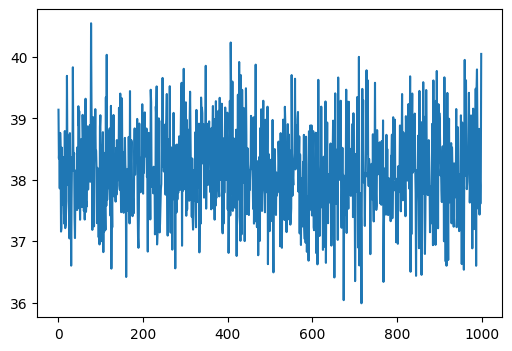

In [70]:
plt.figure(figsize=(6,4))
plt.plot(torch.arange(0,10), lossh_outer)
plt.show()